## Teaching GPT multiple tasks at once with prompt engineering

In [1]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, GPT2LMHeadModel, pipeline, \
                         GPT2Tokenizer
import pandas as pd
from datasets import Dataset

/home/nirmal/miniconda3/envs/TransformNLP/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# https://www.kaggle.com/snap/amazon-fine-food-reviews?select=Reviews.csv

reviews = pd.read_csv('data/reviews.csv')

print(reviews.shape)

reviews.head()

(96512, 3)


,Text,Summary,Score
0,Great taffy at a great price. There was a wid...,Great taffy,5
1,This taffy is so good. It is very soft and ch...,"Wonderful, tasty taffy",5
2,Right now I'm mostly just sprouting this so my...,Yay Barley,5
3,This is a very healthy dog food. Good for thei...,Healthy Dog Food,5
4,good flavor! these came securely packed... the...,fresh and greasy!,4


<Axes: title={'center': 'Histogram of Review Length'}, ylabel='Frequency'>

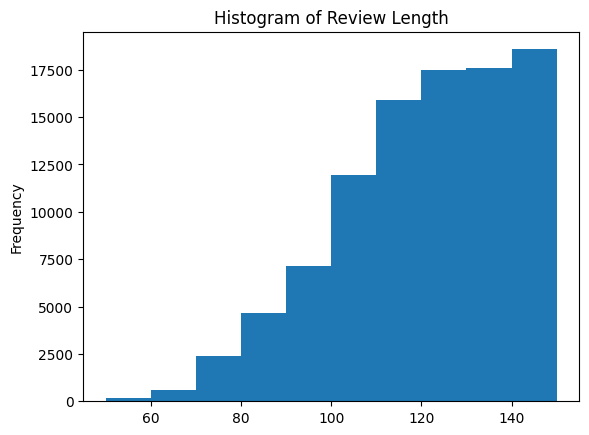

In [3]:
reviews['Text'].str.len().plot(kind='hist', title='Histogram of Review Length')

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

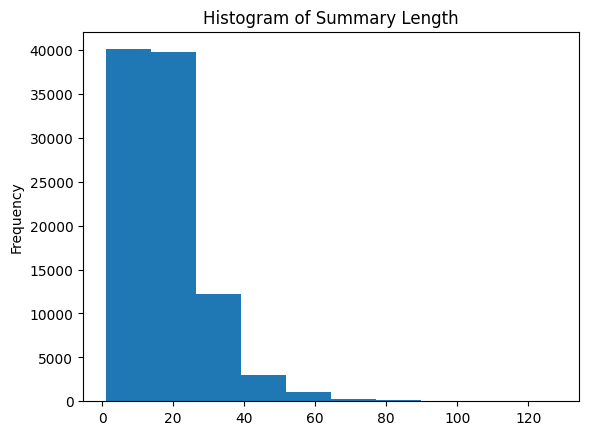

In [4]:
reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

<Axes: title={'center': 'Histogram of Summary Length'}, ylabel='Frequency'>

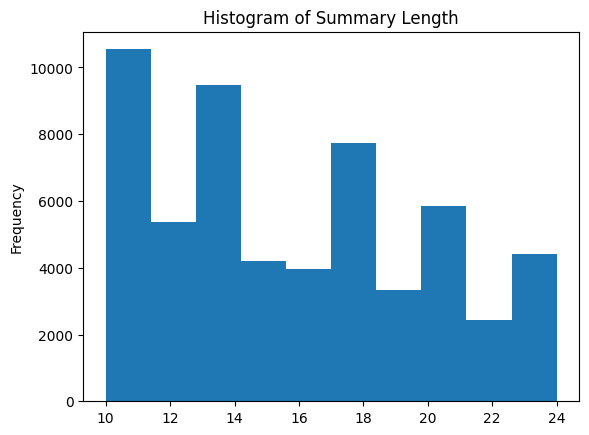

In [5]:
# remove very short and very long summaries
reviews = reviews[(reviews['Summary'].str.len() >= 10) & (reviews['Summary'].str.len() < 25)]

reviews['Summary'].str.len().plot(kind='hist', title='Histogram of Summary Length')

In [6]:
reviews['Sentiment'] = reviews['Score'].map(lambda x: 'positive' if x >= 4 else 'neutral' if x == 3 else 'negative')

# Take 1,000 examples from each sentiment group
reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))

/tmp/ipykernel_79995/1215409365.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  reviews = reviews.groupby('Sentiment', group_keys=False).apply(lambda x: x.sample(1000))


<Axes: >

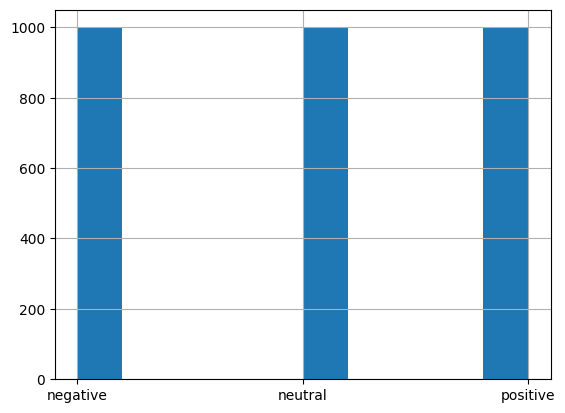

In [7]:
reviews['Sentiment'].hist()

In [8]:
MODEL = 'distilgpt2'

tokenizer = GPT2Tokenizer.from_pretrained(MODEL)

tokenizer.pad_token = tokenizer.eos_token

#add two prompts, one for each task
SENTIMENT_PROMPT = 'Sentiment Task'
SUMMARIZE_PROMPT = 'Summarize Task'
SENTIMENT_TOKEN = '\nSentiment:'
SUMMARIZE_TOKEN = '\nSummarize:'


In [9]:
reviews['sentiment_text'] = f'{SENTIMENT_PROMPT}\nReview: ' + reviews['Text'] + SENTIMENT_TOKEN +  ' ' + reviews['Sentiment'].astype(str)
reviews['summarize_text'] = f'{SUMMARIZE_PROMPT}\nReview: ' + reviews['Text'] + SUMMARIZE_TOKEN +  ' ' + reviews['Summary'].astype(str)

In [10]:
reviews['sentiment_text'].head(2).tolist()

['Sentiment Task\nReview: "Hint" is right, very pleasant, but not chocolatey or minty enough for me.\nSentiment: negative',
 'Sentiment Task\nReview: I do like how these taste but there is too much dietary salt. I also found that after eating two, I began to get stomach knots.\nSentiment: negative']

In [11]:
print('Sentiment Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSentiment: negative')

Sentiment Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Sentiment: negative


In [12]:
reviews['summarize_text'].head(2).tolist()

['Summarize Task\nReview: "Hint" is right, very pleasant, but not chocolatey or minty enough for me.\nSummarize: Irony Mints',
 'Summarize Task\nReview: I do like how these taste but there is too much dietary salt. I also found that after eating two, I began to get stomach knots.\nSummarize: To much dietary salt.']

In [13]:
print('Summarize Task\nReview: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.\nSummarize: Not bad, but bland')

Summarize Task
Review: I just made this for lunch. It had almost no flavor, although it smelled heavenly for the first few minutes of cooking.
Summarize: Not bad, but bland


In [14]:
reviews = reviews.sample(frac=1)

training_examples = reviews['summarize_text'].tolist() + reviews['sentiment_text'].tolist()

# 6,000 = 2 prompts per 1,000 examples from the 3 sentiment groups
print(len(training_examples))

6000


In [15]:
multi_task_df = pd.DataFrame({'text': training_examples})

data = Dataset.from_pandas(multi_task_df)

def preprocess(examples):
    return tokenizer(examples['text'], truncation=True)

data = data.map(preprocess, batched=True)

data = data.train_test_split(train_size=.8)

Map: 100%|██████████| 6000/6000 [00:01<00:00, 3028.86 examples/s]


In [16]:
model = GPT2LMHeadModel.from_pretrained(MODEL)

In [17]:
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

In [18]:
training_args = TrainingArguments(
    output_dir="./gpt2_multitask", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=32,  # batch size for evaluation
    logging_steps=50,
    load_best_model_at_end=True,
    eval_strategy='epoch',
    save_strategy='epoch'
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=data['train'],
    eval_dataset=data['test'],
    data_collator=data_collator
)

trainer.evaluate()

{'eval_loss': 5.013347148895264,
 'eval_model_preparation_time': 0.0012,
 'eval_runtime': 1.2599,
 'eval_samples_per_second': 952.439,
 'eval_steps_per_second': 30.161}

In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Model Preparation Time
1,2.880900,2.748975,0.001200
2,2.750600,2.701201,0.001200


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=300, training_loss=2.9227830505371095, metrics={'train_runtime': 51.4772, 'train_samples_per_second': 186.49, 'train_steps_per_second': 5.828, 'total_flos': 134518833414144.0, 'train_loss': 2.9227830505371095, 'epoch': 2.0})

In [20]:
trainer.evaluate()

{'eval_loss': 2.7012007236480713,
 'eval_model_preparation_time': 0.0012,
 'eval_runtime': 0.9605,
 'eval_samples_per_second': 1249.36,
 'eval_steps_per_second': 39.563,
 'epoch': 2.0}

In [21]:
trainer.save_model()

In [22]:
loaded_model = GPT2LMHeadModel.from_pretrained('./gpt2_multitask')

generator = pipeline('text-generation', model=loaded_model, tokenizer=tokenizer)

Device set to use cuda:0


In [23]:
text_sample, score, summary = reviews.sample(1)[['Text', 'Sentiment', 'Summary']].values[0]

print(text_sample)
print(score)
print(summary)

num_tokens = len(tokenizer(text_sample)['input_ids'])
num_tokens

This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
negative
Ginger Chews


34

In [24]:
sentiment_text_sample = f'{SENTIMENT_PROMPT}\nReview: {text_sample}{SENTIMENT_TOKEN}'
summarize_text_sample = f'{SUMMARIZE_PROMPT}\nReview: {text_sample}{SUMMARIZE_TOKEN}'

In [25]:
print(sentiment_text_sample)

Sentiment Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Sentiment:


In [26]:
print(summarize_text_sample)

Summarize Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Summarize:


In [27]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=1, max_length=num_tokens + 20):
    print(generated_text['generated_text'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Sentiment Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Sentiment: negative.
Sentiment: negative.
Sent


In [28]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Summarize Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Summarize: This candy tastes like a candy and that
----
Summarize Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Summarize: Too bitter to taste this thing!!

----
Summarize Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Summarize: Poor taste!
Summarize:
----


In [29]:
generator = pipeline('text-generation', model=GPT2LMHeadModel.from_pretrained('gpt2'), tokenizer=tokenizer)

Device set to use cuda:0


In [31]:
for generated_text in generator(sentiment_text_sample, num_return_sequences=5, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('-------')

Sentiment Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Sentiment: I didn't want to go to my store expecting
-------
Sentiment Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Sentiment: There were 5 Stars for this item that are definitely
-------
Sentiment Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Sentiment: Wow, if these were old, that must mean
-------
Sentiment Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Sentiment: This is a particularly nice review, which I received
-------
Sentiment Task
Review: This is an excellent item when fresh, whic

In [32]:
for generated_text in generator(summarize_text_sample, num_return_sequences=3, max_length=num_tokens + 20):
    print(generated_text['generated_text'])
    print('----')

Summarize Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Summarize: On top of all that, the items
----
Summarize Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Summarize: Reviewers have described the aroma of these
----
Summarize Task
Review: This is an excellent item when fresh, which these were not. The candies I received were old, shriveled and hard. They should not have been sold.
Summarize: In the end this package was excellent,
----
